# IERG6130 Signal Processing in Wireless Communications and Sensing
## MATLAB Simulation LogBook
| Student Name         | Student ID                |
| :--------------------: | :-------------------------: |
| Han HU  | 1155107763 |

### Raised Cosine Filtering in MATLAB
In this part, we will observe how *Raised Cosine Filtering* will affect the signal.

1. The impulse response

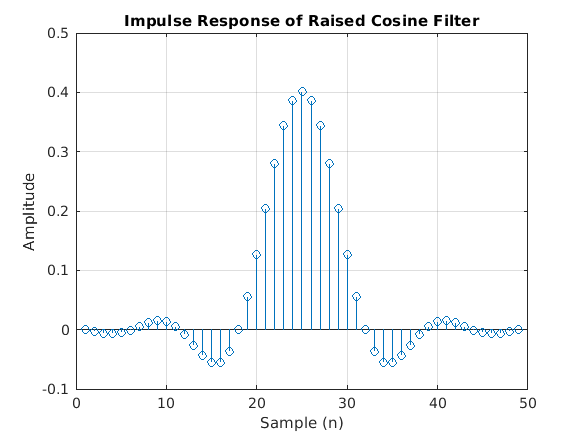

In [6]:
%% parameter settings
Nsym = 6; % FIlter span in symbol duration
beta = 0.5; % Roll-off factor
samplesPerSymbol = 8; % Upsampling factor

%% Define a raised cosine transimitter filter
rcfFilt = comm.RaisedCosineTransmitFilter(...
    'RolloffFactor',beta,...
    'FilterSpanInSymbols',Nsym,...
    'OutputSamplesPerSymbol',samplesPerSymbol);
% Visualize a impulse response
% fvtool(rcfFilt,'Analysis','impulse')

%% Alternative to `fvtool`
% Get filter coefficients
filterCoeffs = coeffs(rcfFilt);
% Calculate impulse response
impulseResponse = filterCoeffs.Numerator;
% Create stem plot of impulse response
stem(impulseResponse);
xlabel('Sample (n)');
ylabel('Amplitude');
title('Impulse Response of Raised Cosine Filter');
grid on;



In [7]:
% Normalize to obtain maximum filter tap value of 1
rcfFilt.Gain = 1/max(filterCoeffs.Numerator);


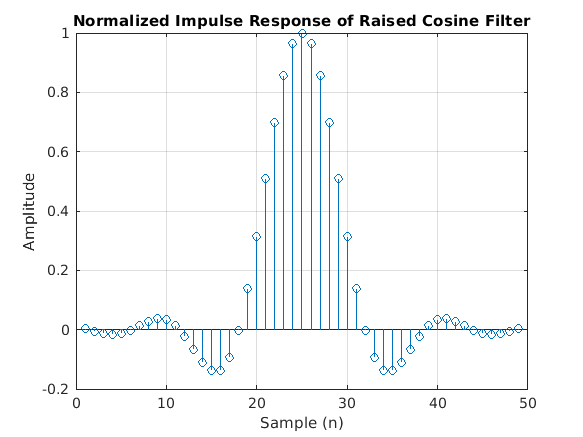

In [8]:
% Visualize the impulse response after normalization
% fvtool(rcfFilt,'Analysis','impulse')

%% Alternative to `fvtool`
% Get filter coefficients
filterCoeffs_normalized = coeffs(rcfFilt);
% Calculate impulse response
impulseResponse = filterCoeffs_normalized.Numerator;
% Create stem plot of impulse response
stem(impulseResponse);
xlabel('Sample (n)');
ylabel('Amplitude');
title('Normalized Impulse Response of Raised Cosine Filter');
grid on;


2. Pulse shaping with raised cosine filter

        A bipolar data sequence is generated.

        No ISI is introduced.   

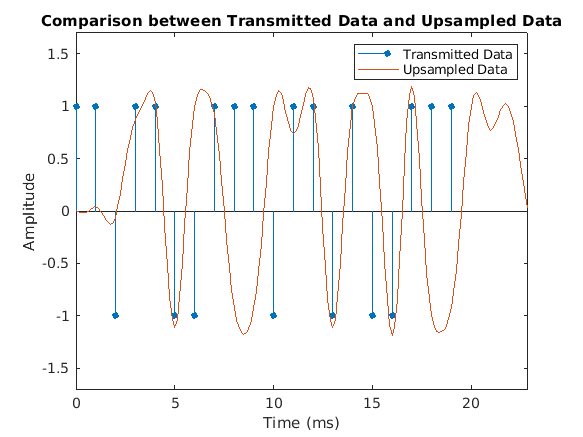

In [10]:
%% Pulse shaping with raised cosine filter
% Bipolar data sequence with no ISI

% Parameters
DataL = 20; % Data length in symbols
R = 1000; % Data rate in symbols per second
Fs = R * samplesPerSymbol; % Sampling frequency in Hz

% Create a local random stream to be used by random number generators for repeatability
hStr = RandStream('mt19937ar','Seed',0);

% Generate random data
data = 2*randi(hStr,[0 1],DataL,1) - 1;
% Time vector sampled at symbol rate in milliseconds
t = (0:DataL-1)/R*1000;

% The plot compares the digital data and the interpolated signal. 
% It is difficult to compare the two signals because the peak response of 
% the filter is delayed by the group delay of the filter (Nsym/(2*R)). 
% Note that we append Nsym/2 zeros at the end of input x to 
% flush all the useful samples out of the filter.

% Filter
yo = rcfFilt([data; zeros(Nsym/2,1)]);
% Time vector sampled at sampling frequency in milliseconds
to = (0:(DataL+Nsym/2)*samplesPerSymbol-1)/Fs*1000;
% Plot data
fig1 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% Plot filtered data
plot(to,yo,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -1.7 1.7]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Upsampled Data');
title('Comparison between Transmitted Data and Upsampled Data');

3. Compensation for Group Delay

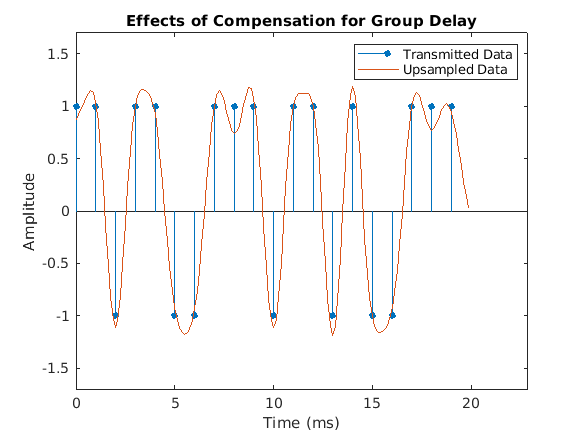

In [11]:
% This step compensates for the raised cosine filter group delay by 
% delaying the input signal. Now it is easy to see how the raised cosine filter 
% upsamples and filters the signal. The filtered signal is identical to 
% the delayed input signal at the input sample times. This shows 
% the raised cosine filter capability to band-limit the signal while avoiding ISI.

% Filter group delay, since raised cosine filter is linear phase and symmetric.
fltDelay = Nsym/(2*R);
% Correct for propagation delay by removing filter transients
y1 = yo(fltDelay*Fs+1:end);
t1 = (0:DataL*samplesPerSymbol-1)/Fs*1000;
% Plot data
fig2 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
plot(t1,y1,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -1.7 1.7]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Upsampled Data');
title('Effects of Compensation for Group Delay');

4. Different roll factor $\beta$ 

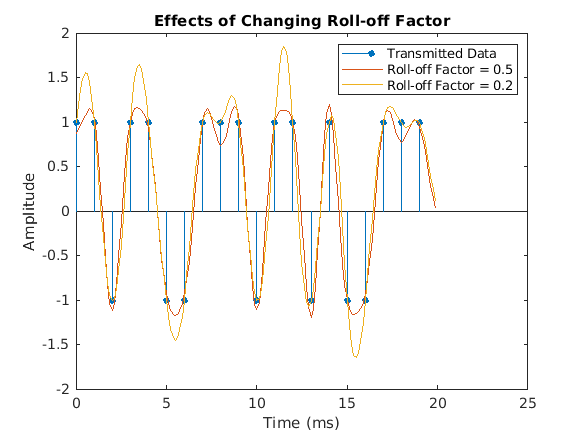

In [15]:
%% Roll-off factor
% This step shows the effect that changing the roll-off factor from .5 (blue curve)
% to .2 (red curve) has on the resulting filtered output. The lower value for 
% roll-off causes the filter to have a narrower transition band 
% causing the filtered signal overshoot to be greater for the red curve 
% than for the blue curve.

% set the roll factor to 0.2
rctFilt2 = comm.RaisedCosineTransmitFilter(...
    'Shape','Normal',...
    'RolloffFactor',0.2,...
    'FilterSpanInSymbols',Nsym,...
    'OutputSamplesPerSymbol',samplesPerSymbol);
% Normalize to obtain maximum filter tap value of 1
b = coeffs(rctFilt2);
rctFilt2.Gain = 1/max(b.Numerator);
% Filter
y2 = rctFilt2([data; zeros(Nsym/2,1)]);
% Correct for propagation delay by removing filter transients
y2 = y2(fltDelay*Fs+1:end);
% Plot data
fig3 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% plot filtered data
plot(t1,y1,'LineWidth',1);
plot(t1,y2,'LineWidth',1);
hold off;
% set axes and labels
axis([0 25 -2 2]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Roll-off Factor = 0.5','Roll-off Factor = 0.2');
title('Effects of Changing Roll-off Factor');

5. Square-Root Raised Cosine Filters

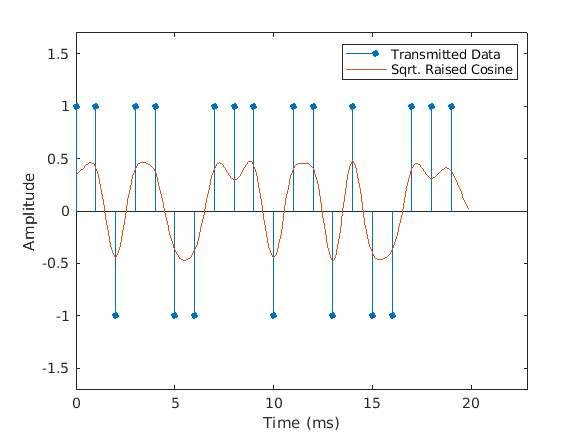

In [29]:
%% Square-Root Raised Cosine Filters
% A typical use of raised cosine filtering is to split the filtering between transmitter and receiver. Both transmitter and receiver employ square-root raised cosine filters. The combination of transmitter and receiver filters is a raised cosine filter, which results in minimum ISI. We specify a square-root raised cosine filter by setting the shape as 'Square root'.

% Design raised cosine filter with given order in symbols
rctFilt3 = comm.RaisedCosineTransmitFilter(...
    'Shape','Square root',...
    'RolloffFactor',beta,...
    'FilterSpanInSymbols',Nsym,...
    'OutputSamplesPerSymbol',samplesPerSymbol);

% The data stream is upsampled and filtered at the transmitter using the designed filter. This plot shows the transmitted signal when filtered using the square-root raised cosine filter.

% Upsample the filter
y3 = rctFilt3([data; zeros(Nsym/2,1)]);
% Correct for propagation delay by removing filter transients
y3 = y3(fltDelay*Fs+1:end);
% Plot data
fig4 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% Plot filtered data
plot(t1,y3,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -1.7 1.7]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Sqrt. Raised Cosine');

    The filtered received signal should look like

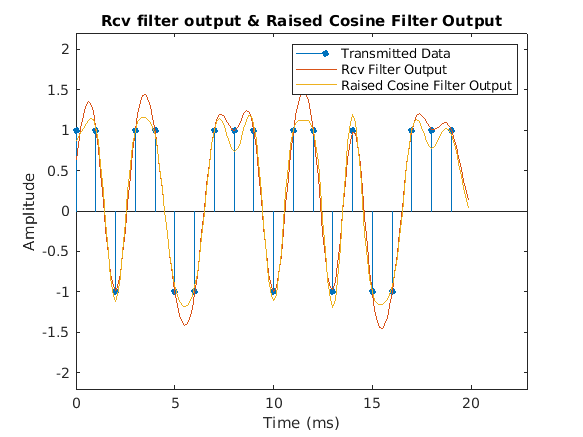

In [26]:
%The transmitted signal (magenta curve) is then filtered at the receiver. We did not decimate the filter output to show the full waveform. The default unit energy normalization ensures that the gain of the combination of the transmit and receive filters is the same as the gain of a normalized raised cosine filter. The filtered received signal, which is virtually identical to the signal filtered using a single raised cosine filter, is depicted by the blue curve at the receiver.

% Design raised cosine filter with given order in symbols
rcrFilt = comm.RaisedCosineReceiveFilter(...
    'Shape','Square root',...
    'RolloffFactor',beta,...
    'FilterSpanInSymbols',Nsym,...
    'InputSamplesPerSymbol',samplesPerSymbol,...
    'DecimationFactor',1);
% Filter at the receiver
yr = rcrFilt([y3; zeros(Nsym*samplesPerSymbol/2,1)]);
% Correct for propagation delay by removing filter transients
yr = yr(fltDelay*Fs+1:end);
% Plot data
fig5 = figure;
stem(t,data,'filled','MarkerSize',4);
hold on;
% Plot filtered data
plot(t1,yr,'LineWidth',1);
plot(t1,y1,'LineWidth',1);
hold off;
% set axes and labels
axis([0 to(end) -2.2 2.2]);
xlabel('Time (ms)');
ylabel('Amplitude');
legend('Transmitted Data','Rcv Filter Output', ...
    'Raised Cosine Filter Output');
title('Rcv filter output & Raised Cosine Filter Output');

6. Computational Cost

In [30]:
%% Computational Cost
% In the following table, we compare the computational cost of 
% a polyphase FIR interpolation filter and polyphase FIR decimation filter.
C1 = cost(rctFilt3)
C2 = cost(rcrFilt)

C1 = struct with fields:
   NumCoefficients: 49
                        NumStates: 6
    MultiplicationsPerInputSample: 49
          AdditionsPerInputSample: 41

C2 = struct with fields:
   NumCoefficients: 49
                        NumStates: 48
    MultiplicationsPerInputSample: 49
          AdditionsPerInputSample: 48

### Passband Modulation
In this part, a **Simulink** model is used to observe the basic *Passband Modulation*.

1. The overview of the simulink model
![Passband](resources/PassbandModulationExample_01.png)